# Background

The data was obtained from Kaggle (https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis) with a CC0: Public Domain license. The data was inspected, features were created/modified and outliers removed. The created features/modified were:

Created:
- Customer Age
- Total Expenses
- Seniority
- Child Count (Number of Children)
- Has Child (Boolean for children)

Modified:
- Marital Status
- Education

Outliers were removed using scatterplots and boxplots with visual inspection. The prepared data was pickled along with the features to be used for clustering in a list. Pearson correlations were also calculated and the following was determined:

- Income vs Expenses are correlated positively (+0.83)
- Children vs Income (-0.35) and Children vs Expenses (-0.5) are negativly correlated

The rest show little to no correlation. PCA might be useful to help reduce dimensions with the non-correlated sets.

# Goal

Apply K-means and PCA to segment the data based on the features to use.

# Imports

In [1]:
# data tools
import numpy as np
import pandas as pd
import pickle as pkl


# inspection tools
# from IPython.core.display import HTML
# from dataprep.eda import plot, plot_correlation, create_report, plot_missing

# date handling
# import datetime
# from datetime import date

# graphing
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
sns.set()

# machine learning
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# import warnings
# warnings.filterwarnings('ignore')

# Functions



In [2]:
# Function to display informative elbow method for clusters

def test_clusters(X, random_state, max_clusters, metric='distortion'):
    model = KMeans(random_state=random_state, n_init=10, max_iter=300, tol=1e-04, init='k-means++')
    if metric == 'distortion':
        elb_visualiser = KElbowVisualizer(model, k=(1,max_clusters), metric=metric)
    else:
        elb_visualiser = KElbowVisualizer(model, k=(2,max_clusters), metric=metric)
    elb_visualiser.fit(X)
    return elb_visualiser.show()

# Function to display informative silhouette method for clusters

def silhouette_clusters(X, random_state, number_of_clusters):
    model = KMeans(n_clusters=number_of_clusters, random_state=random_state, n_init=10, max_iter=300, tol=1e-04, init='k-means++')
    
    sil_visualiser = SilhouetteVisualizer(model)
    sil_visualiser.fit(X)
    return sil_visualiser.show()

# Function to perform PCA analysis
def pca_analysis(X, num_components):
    if num_components == 'find':
        pca = PCA()
        pca.fit(X)
    else:
        pca = PCA(n_components=num_components)
        pca.fit(X)
    return pca

# function to get component loadings from PCA
def get_comp_loadings(pca_components, cols, index):
    df_pca_comp = pd.DataFrame(data = pca_components, columns=cols, index = index)
    return df_pca_comp


# Load Data

In [3]:
with open('customer_data_without_outliers.pickle', 'rb') as handle:
    dict = pkl.load(handle)

In [4]:
dict['cluster_features']

['Income',
 'Recency',
 'Customer Age',
 'Total Expenses',
 'Seniority',
 'Children']

In [5]:
# Unpack the data
data = dict['data']
features = ['Income',
            'Recency',
            'Customer Age',
            'Total Expenses',
            'Seniority',
            'Children']

#  Select clustering features
segm_data = data[features].copy()
segm_data

Income  Recency  Customer Age  Total Expenses  Seniority  Children
ID                                                                        
5524   58138.0       58            57            1617  25.333333         0
2174   46344.0       38            60              27   7.000000         2
4141   71613.0       26            49             776  13.633333         0
6182   26646.0       26            30              53   7.866667         1
5324   58293.0       94            33             422   8.600000         1
...        ...      ...           ...             ...        ...       ...
10870  61223.0       46            47            1341  15.933333         1
4001   64014.0       56            68             444   3.866667         3
7270   56981.0       91            33            1241   8.400000         0
8235   69245.0        8            58             843   8.433333         1
9405   52869.0       40            60             172  23.966667         2

[2203 rows x 6 columns]

# Scale the data

In [6]:
# Use standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(segm_data)

# Normalisation
# X_norm = normalize(X_std,norm='l2')

X = X_scaled.copy()

# PCA

In [7]:
# get the components
pca = pca_analysis(X, 'find')

#show the number of components
pca.components_.shape

(6, 6)

In [8]:
number_of_components = pca.components_.shape[0]

Text(0, 0.5, 'Cumulative Explained Varience')

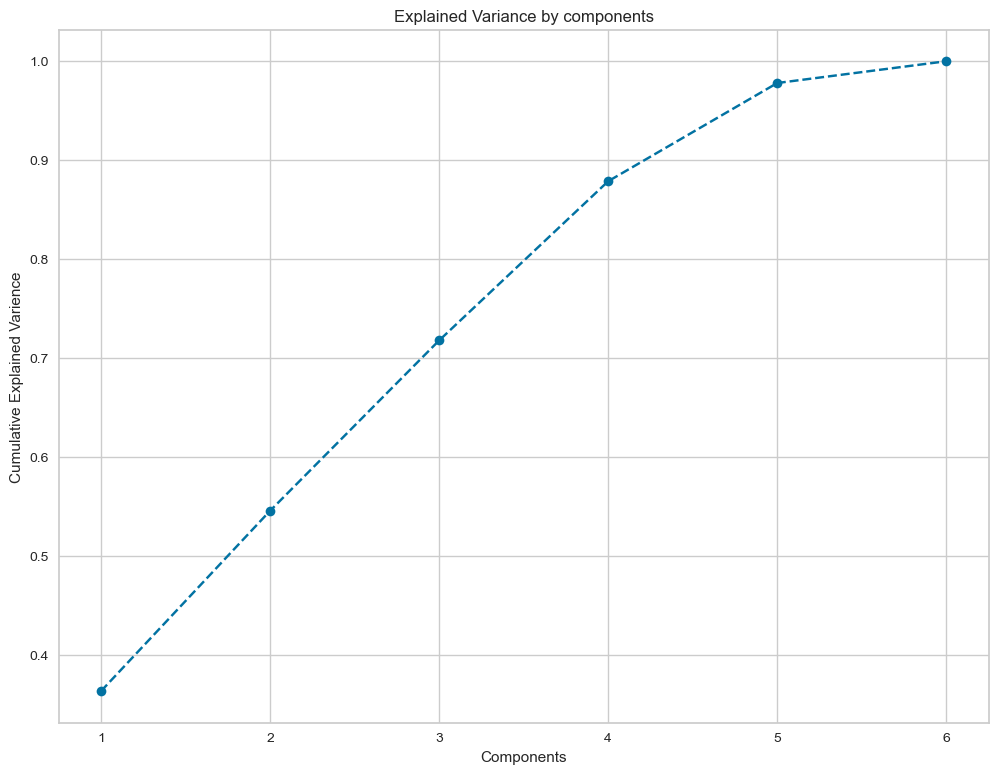

In [9]:
# Plot cumulative variance vs components

plt.figure(figsize=(12,9))
plt.plot(range(1, number_of_components+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title("Explained Variance by components")
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Varience")

70-80% Explained varience is a good benchmark, we can reduce the dimensionality to 3 components

In [10]:
Number_of_components_to_use = 3
pca = pca_analysis(X, Number_of_components_to_use)

## PCA Results

In [11]:
pca_comp = get_comp_loadings(pca.components_, features, ['Component 1', 'Component 2', 'Component 3'])
pca_comp

Income   Recency  Customer Age  Total Expenses  Seniority  \
Component 1  0.605806  0.013145      0.136901        0.640739   0.083189   
Component 2  0.174998  0.151226      0.838228       -0.023711  -0.259683   
Component 3  0.083978 -0.681993     -0.054744       -0.046639  -0.712340   

             Children  
Component 1 -0.443416  
Component 2  0.419384  
Component 3 -0.123422

### PCA pearson correlations to features

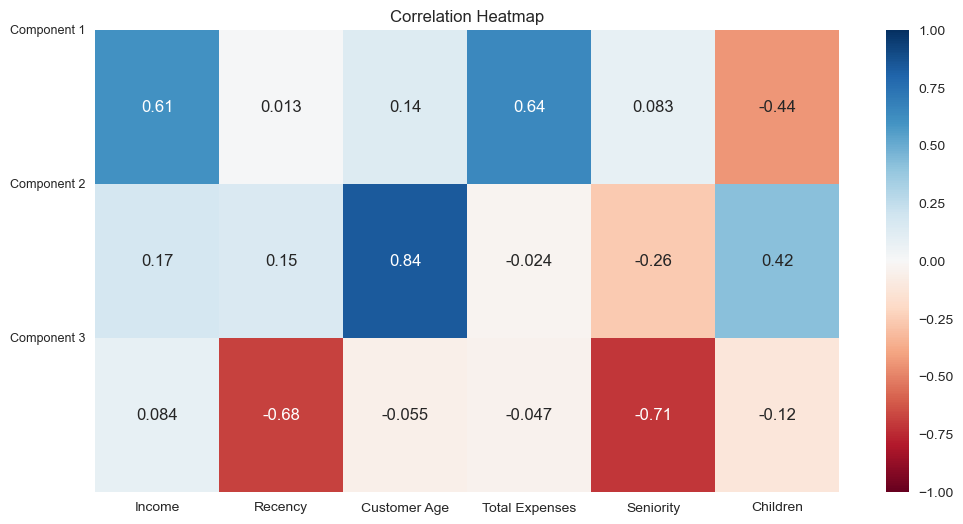

In [12]:
plt.figure(figsize=(12,6))
s = sns.heatmap(pca_comp,
               annot=True,
               cmap='RdBu',
               vmin=-1,
               vmax=1)
plt.yticks([0,1,2], ['Component 1', 'Component 2', 'Component 3'], rotation = 0, fontsize = 9)
plt.title("Correlation Heatmap")
plt.show()

It seems that Component 1 is positively correlated to Income (0.61) and Total Expenses (0.64) whilst negatively correlated with the number of children (-0.44). Component 2 seems positivly correlated with Age (0.84) and the number of children (0.42), whilst being negativly correlated with Seniority (-0.26). Component 3 is negativly correlated with Recency (-0.68) and Seniority (-0.71)

The rest are loosely correlated.

In [13]:
# get the PCA scores
scores_pca = pca.transform(X)
scores_pca

array([[ 2.10053826, -0.01202792, -1.25070243],
       [-1.32356812,  1.88629825,  0.88783529],
       [ 1.34729237, -0.15511948,  0.89624985],
       ...,
       [ 1.19125652, -0.90300296, -0.10455528],
       [ 0.79037361,  1.13303488,  1.64782153],
       [-0.76756638,  1.29345756, -0.93495013]])

# Hierarchical Clustering


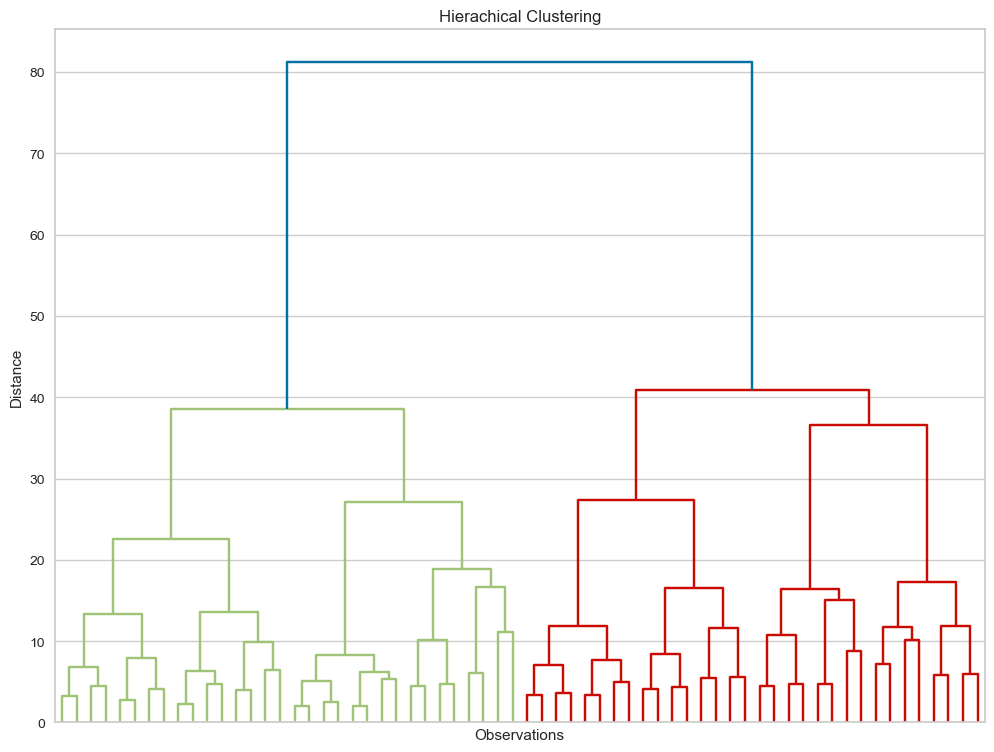

In [14]:
hier_clus = linkage(scores_pca, method='ward')

plt.figure(figsize=(12, 9))
plt.title("Hierachical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hier_clus,
           truncate_mode='level',
           p=5,
           show_leaf_counts=False,
           no_labels=True,
           # color_threshold=0
           )
plt.show()

# K-means
## Choosing number of clusters

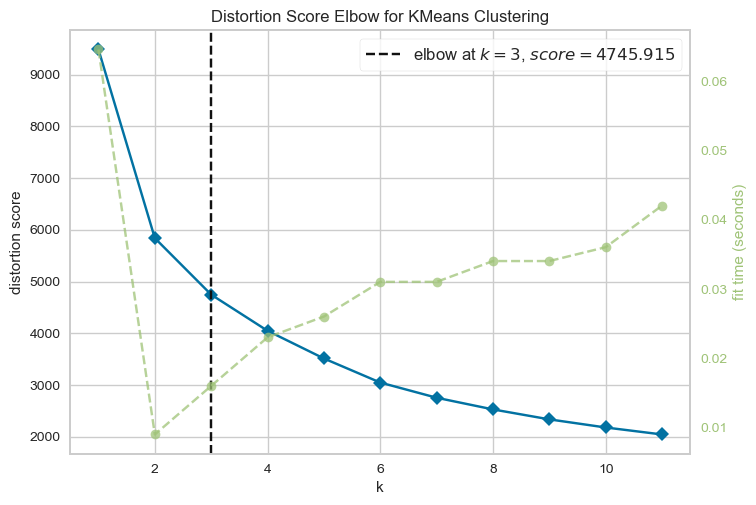

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
test_clusters(X=scores_pca, random_state=1, max_clusters=12, metric='distortion')

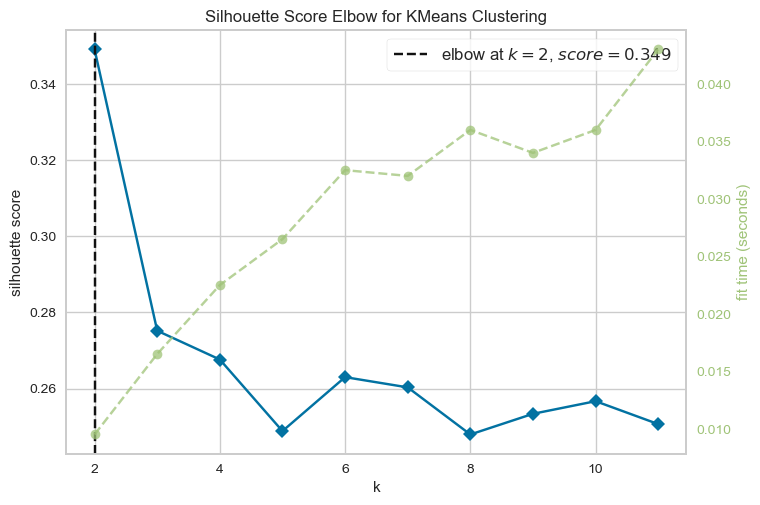

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [16]:
test_clusters(X=scores_pca, random_state=1, max_clusters=12, metric='silhouette')

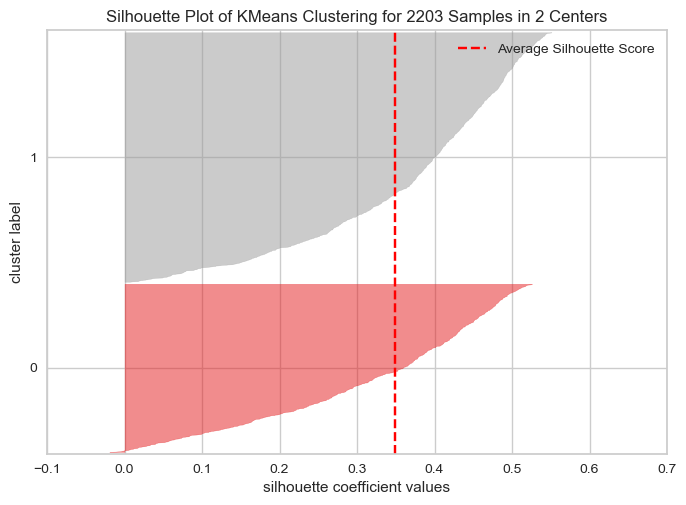

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=2)

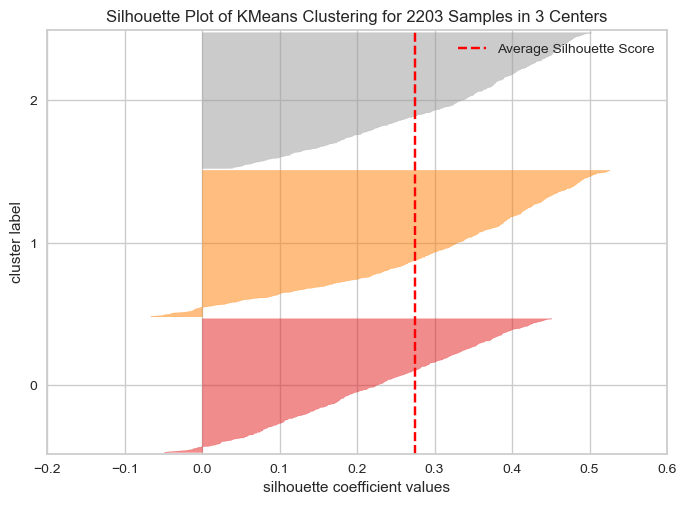

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=3)

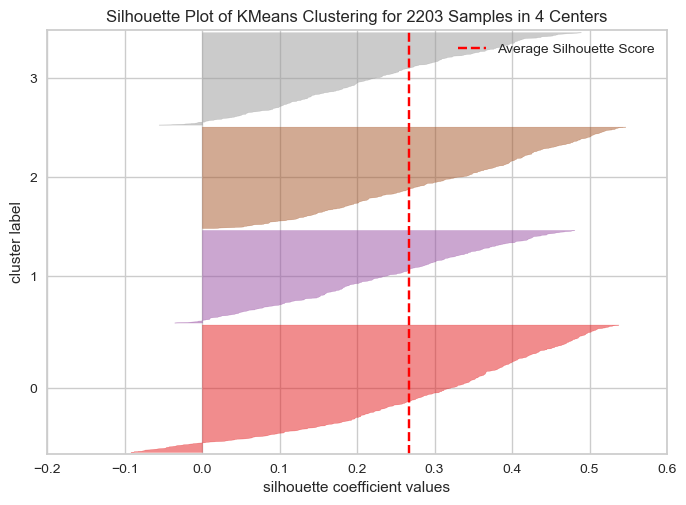

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [19]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=4)

## Cluster selection

The number of clusters to select seem to point to choosing 2 clusters. This is based on the Silhoette score as well as the Dendrogram. We could choose 3 based on the elbow method, however often a simpler model is best. We will compare them side by side


In [20]:
# choose two clusters and fit
kmeans_2_clus = KMeans(n_clusters=2, init='k-means++', random_state=1)
kmeans_2_clus.fit(scores_pca)

KMeans(n_clusters=2, random_state=1)

In [21]:
# choose three clusters and fit
kmeans_3_clus = KMeans(n_clusters=3, init='k-means++', random_state=1)
kmeans_3_clus.fit(scores_pca)


KMeans(n_clusters=3, random_state=1)

In [22]:
# choose two clusters and fit
kmeans_4_clus = KMeans(n_clusters=4, init='k-means++', random_state=1)
kmeans_4_clus.fit(scores_pca)

KMeans(n_clusters=4, random_state=1)

## Results PCA K-means

In [23]:
# Copying unscaled data and merging with PCA components for 2, 3 and 4 clusters
segm_pca_kmeans_2_clus = pd.concat([segm_data[features].reset_index(drop=False),
                                    pd.DataFrame(scores_pca)], axis=1)
segm_pca_kmeans_2_clus.columns.values[-3:] = ['Component 1',
                                              'Component 2',
                                              'Component 3']
segm_pca_kmeans_3_clus = segm_pca_kmeans_2_clus.copy()
segm_pca_kmeans_4_clus = segm_pca_kmeans_2_clus.copy()

# copy the labels from the models
segm_pca_kmeans_2_clus['Segment K-means PCA'] = kmeans_2_clus.labels_
segm_pca_kmeans_3_clus['Segment K-means PCA'] = kmeans_3_clus.labels_
segm_pca_kmeans_4_clus['Segment K-means PCA'] = kmeans_4_clus.labels_

# Calculate the means per cluster
segm_pca_kmeans_2_clus_means = segm_pca_kmeans_2_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)
segm_pca_kmeans_3_clus_means = segm_pca_kmeans_3_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)
segm_pca_kmeans_4_clus_means = segm_pca_kmeans_4_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)

# Calculate the number of observations
segm_pca_kmeans_2_clus_means['N Obs'] = segm_pca_kmeans_2_clus[[
    'Segment K-means PCA', 'Customer Age']].groupby(['Segment K-means PCA']).count()
segm_pca_kmeans_3_clus_means['N Obs'] = segm_pca_kmeans_3_clus[[
    'Segment K-means PCA', 'Customer Age']].groupby(['Segment K-means PCA']).count()
segm_pca_kmeans_4_clus_means['N Obs'] = segm_pca_kmeans_4_clus[[
    'Segment K-means PCA', 'Customer Age']].groupby(['Segment K-means PCA']).count()

# Calculate the percentage of observations
segm_pca_kmeans_2_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_2_clus_means['N Obs']/segm_pca_kmeans_2_clus_means['N Obs'].sum())*100).round(2)
segm_pca_kmeans_3_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_3_clus_means['N Obs']/segm_pca_kmeans_3_clus_means['N Obs'].sum())*100).round(2)
segm_pca_kmeans_4_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_4_clus_means['N Obs']/segm_pca_kmeans_4_clus_means['N Obs'].sum())*100).round(2)

In [24]:
segm_pca_kmeans_2_clus_means.drop("ID", axis = 1, inplace=True)
segm_pca_kmeans_2_clus_means

Segment K-means PCA        Income    Recency  Customer Age  Total Expenses  \
0                    0  71448.630214  49.854566     47.653890     1228.509583   
1                    1  38248.938450  48.474924     43.360942      187.193769   

   Seniority  Children  Component 1  Component 2  Component 3  N Obs  \
0  15.803758  0.472379     1.566897     0.034813    -0.002570    887   
1  14.501798  1.270517    -1.056108    -0.023464     0.001732   1316   

   Percent Obs  
0        40.26  
1        59.74

In [25]:
segm_pca_kmeans_3_clus_means.drop("ID", axis = 1, inplace=True)
segm_pca_kmeans_3_clus_means

Segment K-means PCA        Income    Recency  Customer Age  Total Expenses  \
0                    0  47192.137006  54.336158     52.817797      301.810734   
1                    1  72958.493557  48.784794     46.416237     1299.487113   
2                    2  32938.406120  44.070932     36.047288      158.485396   

   Seniority  Children  Component 1  Component 2  Component 3  N Obs  \
0  13.473917  1.538136    -0.729308     0.945614    -0.088838    708   
1  15.905498  0.394330     1.719306    -0.097096     0.031201    776   
2  15.605146  0.968011    -1.137456    -0.826353     0.053805    719   

   Percent Obs  
0        32.14  
1        35.22  
2        32.64

In [26]:
segm_pca_kmeans_4_clus_means.drop("ID", axis = 1, inplace=True)
segm_pca_kmeans_4_clus_means

Segment K-means PCA        Income    Recency  Customer Age  Total Expenses  \
0                    0  74263.286136  48.330383     46.087021     1357.538348   
1                    1  46974.237323  30.805274     48.217039      273.259635   
2                    2  30903.387037  47.388889     34.577778      152.731481   
3                    3  47792.483740  70.058943     52.117886      403.317073   

   Seniority  Children  Component 1  Component 2  Component 3  N Obs  \
0  15.949951  0.308260     1.866880    -0.164194     0.053747    678   
1   9.106085  1.326572    -0.759289     0.541763     0.984726    493   
2  17.005247  0.905556    -1.164759    -1.020189    -0.162874    540   
3  17.512398  1.502033    -0.533426     0.803123    -0.882030    492   

   Percent Obs  
0        30.78  
1        22.38  
2        24.51  
3        22.33

It seems that choosing 2 clusters result in a 40/60 split in the data. However choosing 3 clusters results in a more homogeous split. Choosing 4 clusters is still relativly homogenous. In general we can find better sepration in Age and children with more clusters which also gives more divisions for Income and spending.

Assuming 2 clusters we observe the following on average:

- Cluster 0 = High income, High Expenses, zero to 1 child = Career focused, Well-off
- Cluster 1 = Low income, Low Expenses, 1 or more children = Family orientated

Assuming 3 clusters we observe the following on average:

- Cluster 0 = Med income, not recent, Elder, Med expenses, 1 or more children = Family oriented, conservative spender
- Cluster 1 = High income, med recency, Middle Aged, High Expenses, 0 to 1 Child = Career focused, Well off
- Cluster 2 = Low income, more recent, Younger, Low Expenses, 0 to 1 Child = Young professionals, savvy spender


Assuming 4 clusters we observe the following on average:

- Cluster 0 = High income, med recency, middle aged, High expenses, long time customer, 0-1 child = Career focused, well off, old customer
- Cluster 1 = Med income, more recent, middle aged, low-med expenses, Newer customer, 1 or more children = Family oriented, conservative spender, newer customer
- Cluster 3 = Low income, med recency, younger, low expenses, long time customer, 0-1 child = Young professionals, savvy spender, old customer 
- Cluster 4 = Med income, not recent, elder, ,med expenses, long time customer, 1 or more children = Elder family oriented, intermediate spenders, old customer


## Rename the segments

In [27]:
segm_pca_kmeans_2_clus_means.rename({0: 'Career focused, Well-off',
                                 1: 'Family orientated'})



Segment K-means PCA        Income    Recency  \
Career focused, Well-off                    0  71448.630214  49.854566   
Family orientated                           1  38248.938450  48.474924   

                          Customer Age  Total Expenses  Seniority  Children  \
Career focused, Well-off     47.653890     1228.509583  15.803758  0.472379   
Family orientated            43.360942      187.193769  14.501798  1.270517   

                          Component 1  Component 2  Component 3  N Obs  \
Career focused, Well-off     1.566897     0.034813    -0.002570    887   
Family orientated           -1.056108    -0.023464     0.001732   1316   

                          Percent Obs  
Career focused, Well-off        40.26  
Family orientated               59.74

In [28]:
segm_pca_kmeans_3_clus_means.rename({0:'Family oriented, conservative spender',
                                 1: 'Career focused, Well off',
                                 2:  'Young professionals, savvy spender'})

Segment K-means PCA        Income  \
Family oriented, conservative spender                    0  47192.137006   
Career focused, Well off                                 1  72958.493557   
Young professionals, savvy spender                       2  32938.406120   

                                         Recency  Customer Age  \
Family oriented, conservative spender  54.336158     52.817797   
Career focused, Well off               48.784794     46.416237   
Young professionals, savvy spender     44.070932     36.047288   

                                       Total Expenses  Seniority  Children  \
Family oriented, conservative spender      301.810734  13.473917  1.538136   
Career focused, Well off                  1299.487113  15.905498  0.394330   
Young professionals, savvy spender         158.485396  15.605146  0.968011   

                                       Component 1  Component 2  Component 3  \
Family oriented, conservative spender    -0.729308     0.945614    -0.088838   
Career focused, Well off                  1.719306    -0.097096     0.031201   
Young professionals, savvy spender       -1.137456    -0.826353     0.053805   

                                       N Obs  Percent Obs  
Family oriented, conservative spender    708        32.14  
Career focused, Well off                 776        35.22  
Young professionals, savvy spender       719        32.64

In [29]:
segm_pca_kmeans_4_clus_means.rename({0: 'Career focused, well off, old customer',
                                 1: 'Family oriented, conservative spender, newer customer',
                                 2: 'Young professionals, savvy spender, old customer',
                                 3: 'Elder family oriented, intermediate spenders, old customer'})

Segment K-means PCA  \
Career focused, well off, old customer                                0   
Family oriented, conservative spender, newer cu...                    1   
Young professionals, savvy spender, old customer                      2   
Elder family oriented, intermediate spenders, o...                    3   

                                                          Income    Recency  \
Career focused, well off, old customer              74263.286136  48.330383   
Family oriented, conservative spender, newer cu...  46974.237323  30.805274   
Young professionals, savvy spender, old customer    30903.387037  47.388889   
Elder family oriented, intermediate spenders, o...  47792.483740  70.058943   

                                                    Customer Age  \
Career focused, well off, old customer                 46.087021   
Family oriented, conservative spender, newer cu...     48.217039   
Young professionals, savvy spender, old customer       34.577778   
Elder family oriented, intermediate spenders, o...     52.117886   

                                                    Total Expenses  Seniority  \
Career focused, well off, old customer                 1357.538348  15.949951   
Family oriented, conservative spender, newer cu...      273.259635   9.106085   
Young professionals, savvy spender, old customer        152.731481  17.005247   
Elder family oriented, intermediate spenders, o...      403.317073  17.512398   

                                                    Children  Component 1  \
Career focused, well off, old customer              0.308260     1.866880   
Family oriented, conservative spender, newer cu...  1.326572    -0.759289   
Young professionals, savvy spender, old customer    0.905556    -1.164759   
Elder family oriented, intermediate spenders, o...  1.502033    -0.533426   

                                                    Component 2  Component 3  \
Career focused, well off, old customer                -0.164194     0.053747   
Family oriented, conservative spender, newer cu...     0.541763     0.984726   
Young professionals, savvy spender, old customer      -1.020189    -0.162874   
Elder family oriented, intermediate spenders, o...     0.803123    -0.882030   

                                                    N Obs  Percent Obs  
Career focused, well off, old customer                678        30.78  
Family oriented, conservative spender, newer cu...    493        22.38  
Young professionals, savvy spender, old customer      540        24.51  
Elder family oriented, intermediate spenders, o...    492        22.33

In [30]:
# Map the segments onto observations

In [31]:
segm_pca_kmeans_2_clus['Labels'] = segm_pca_kmeans_2_clus['Segment K-means PCA'].map({0: 'Career focused, Well-off',
                                                                            1: 'Family orientated'})
segm_pca_kmeans_3_clus['Labels'] = segm_pca_kmeans_3_clus['Segment K-means PCA'].map({0: 'Family oriented, conservative spender',
                                                                            1: 'Career focused, Well off',
                                                                            2:  'Young professionals, savvy spender'})
segm_pca_kmeans_4_clus['Labels'] = segm_pca_kmeans_4_clus['Segment K-means PCA'].map({0: 'Career focused, well off, old customer',
                                                                            1: 'Family oriented, conservative spender, newer customer',
                                                                            2: 'Young professionals, savvy spender, old customer',
                                                                            3: 'Elder family oriented, intermediate spenders, old customer'})

# Plot the clusters

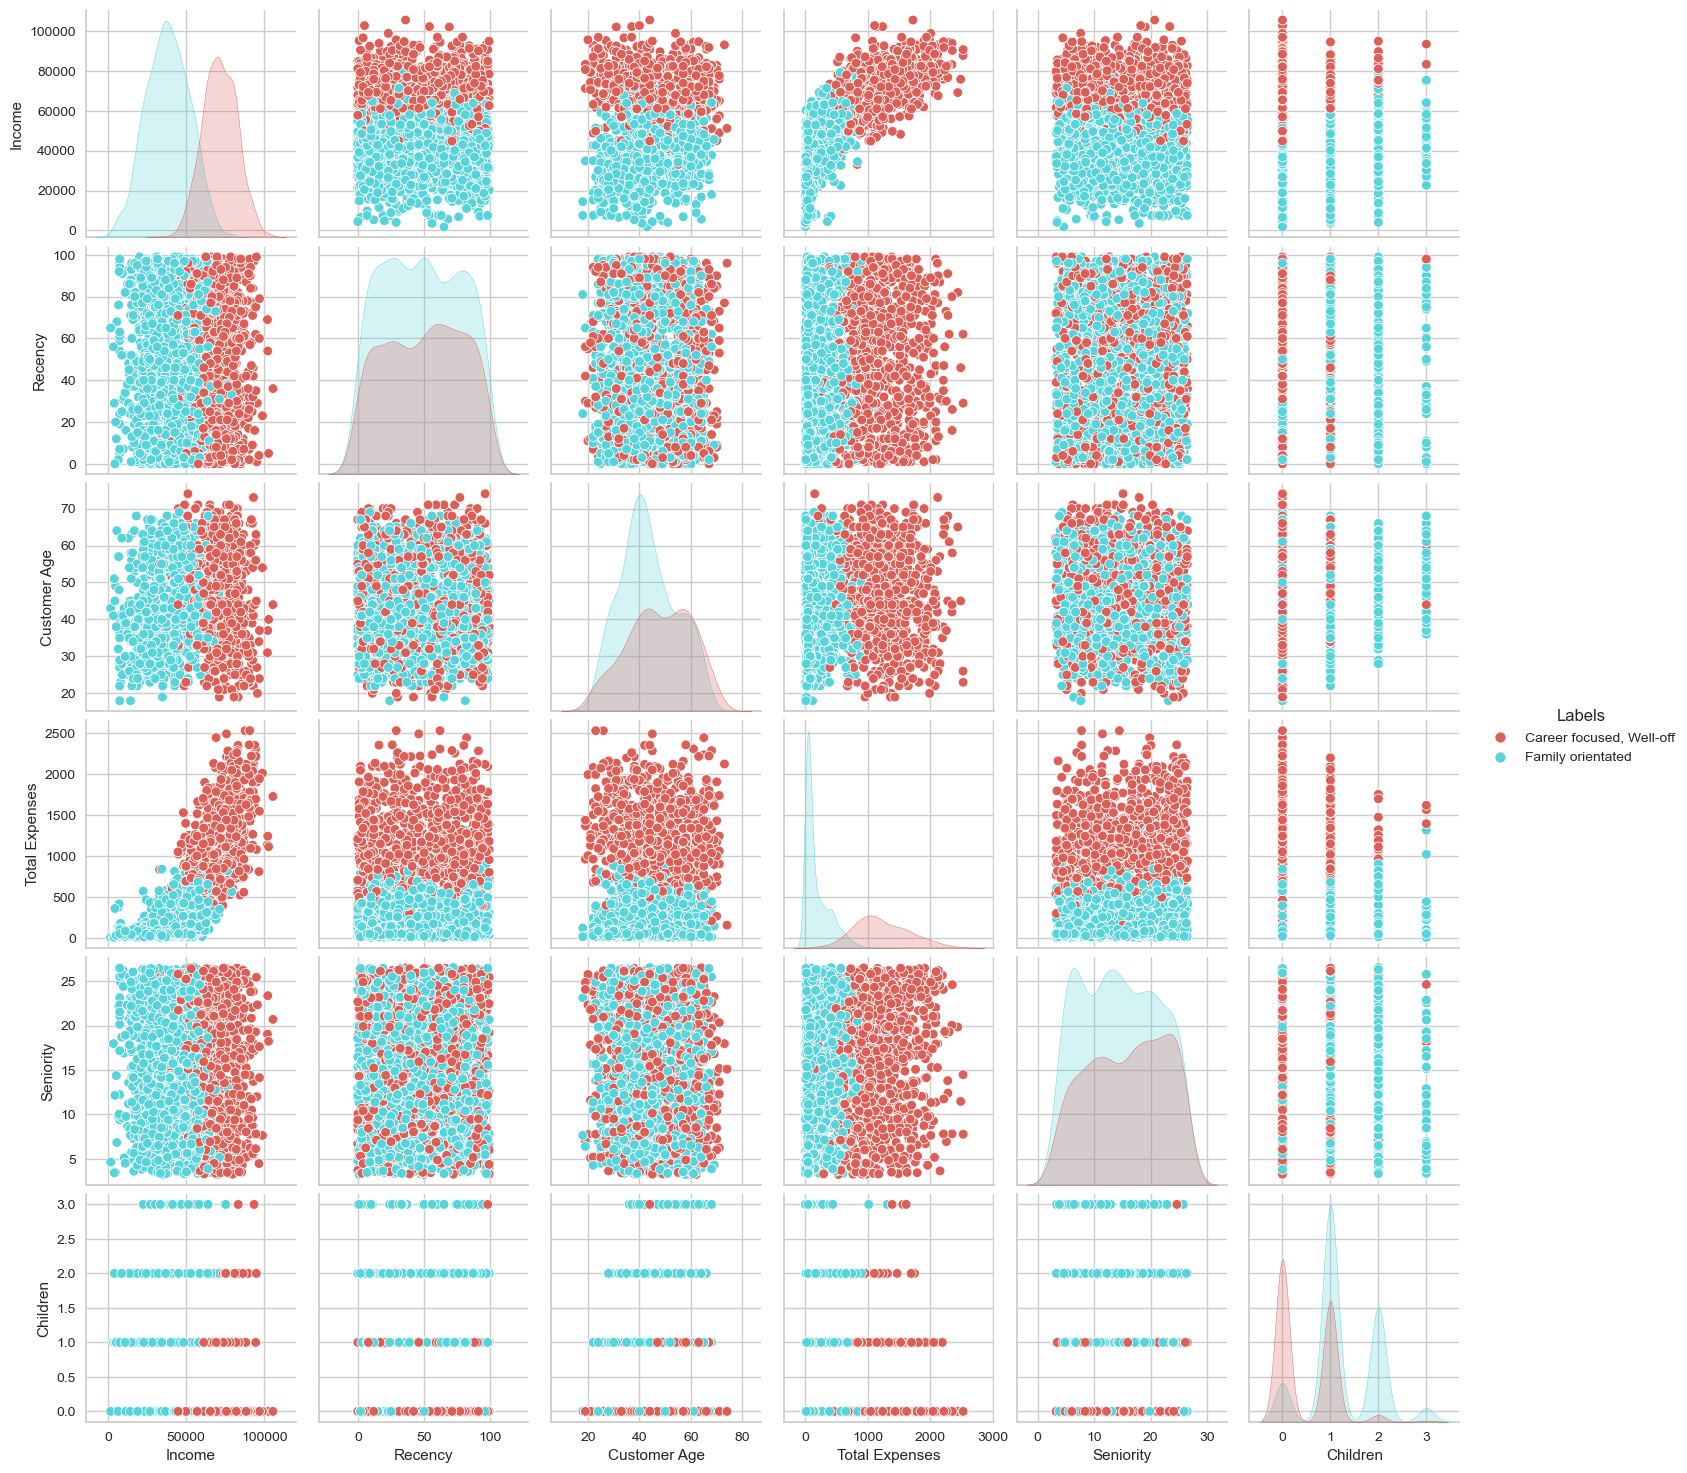

In [32]:
sns.pairplot(segm_pca_kmeans_2_clus, vars=features, hue='Labels', palette=sns.color_palette('hls',2))

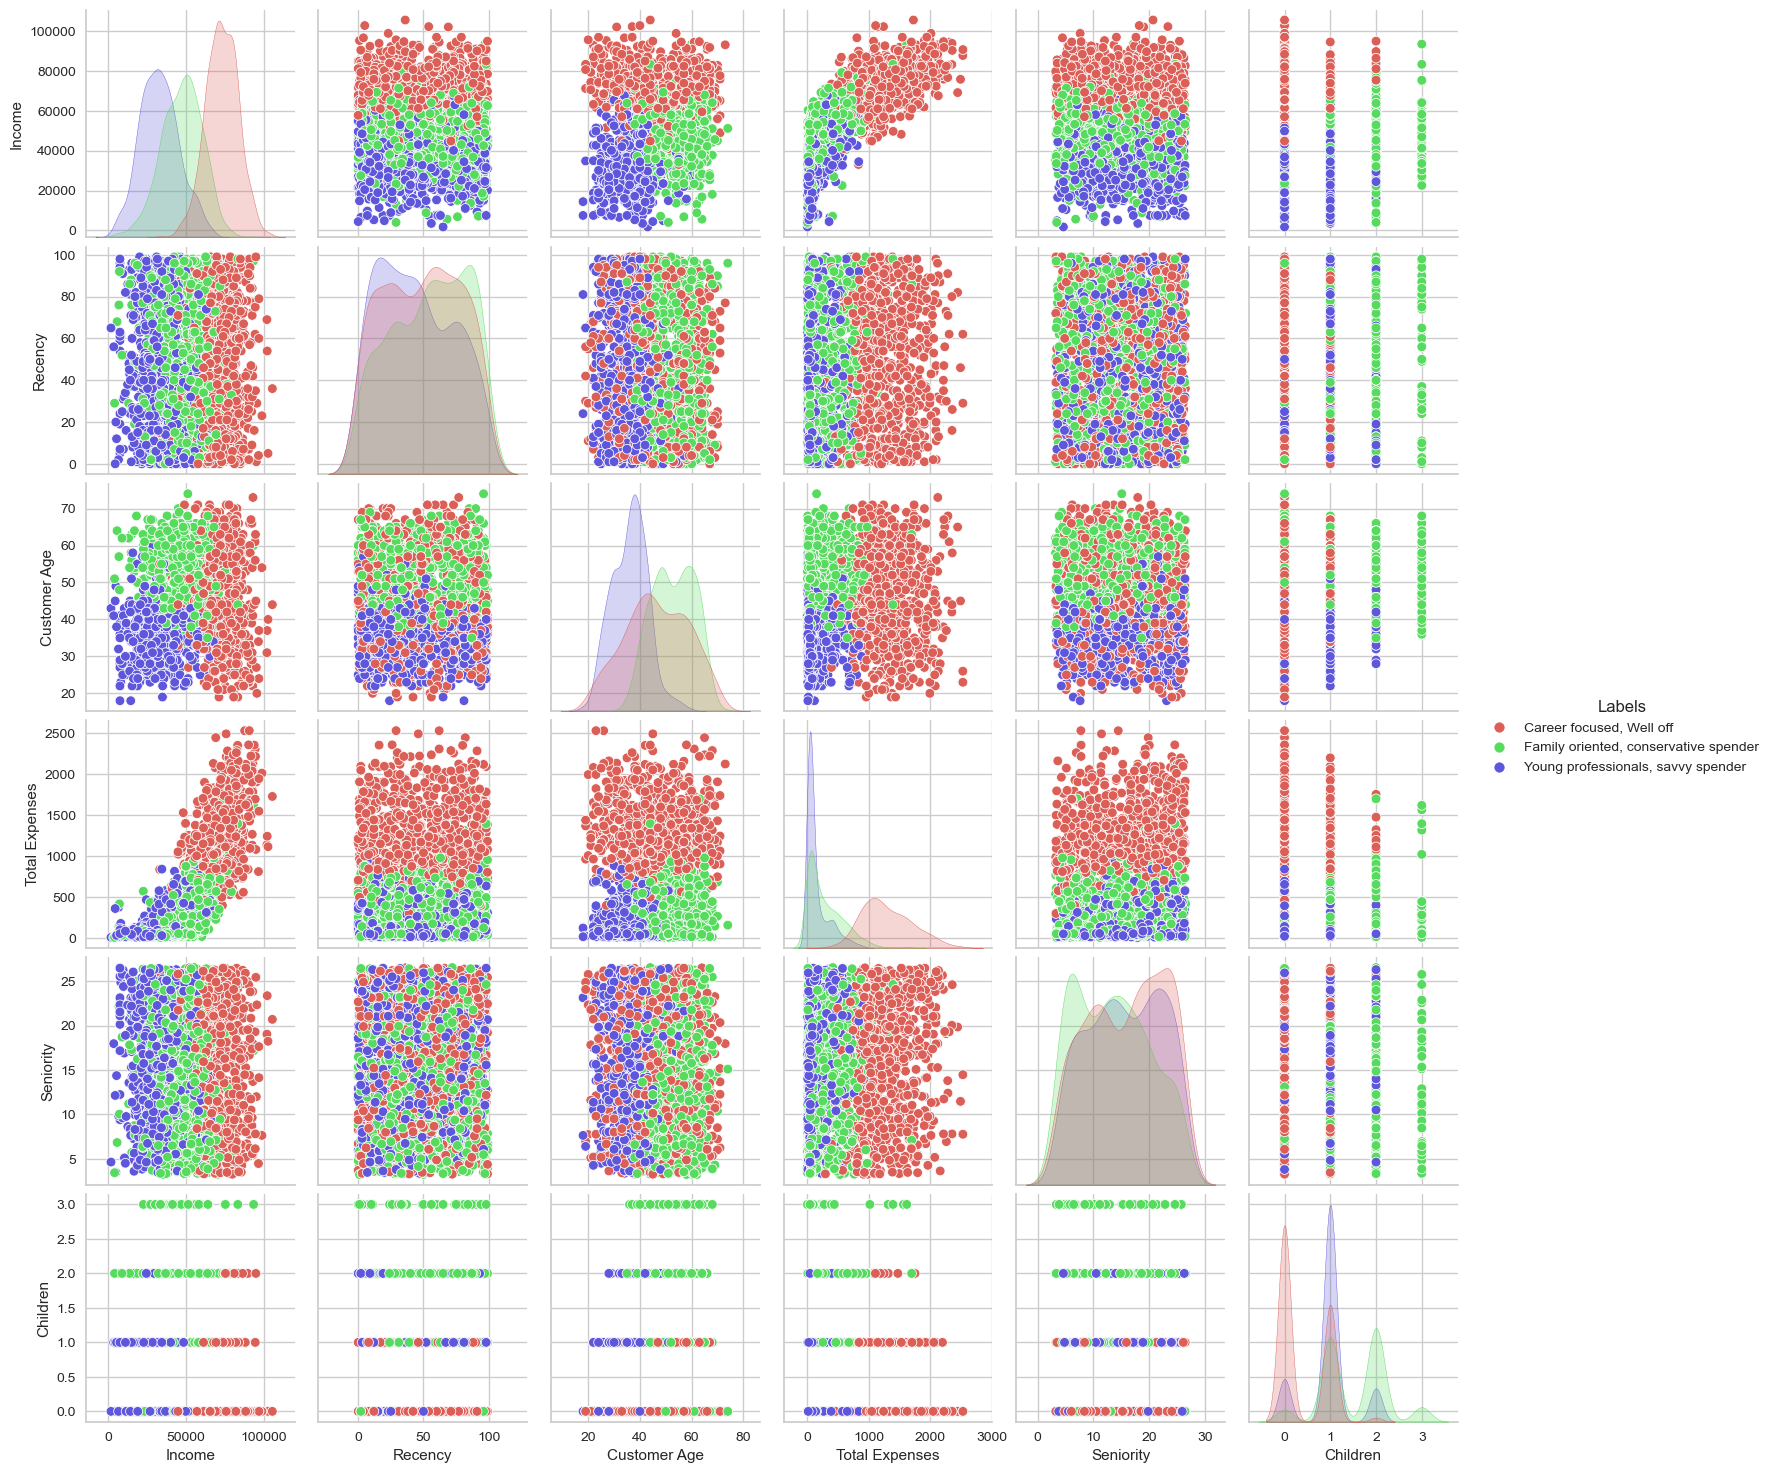

In [33]:
sns.pairplot(segm_pca_kmeans_3_clus, vars=features, hue='Labels', palette=sns.color_palette('hls',3))

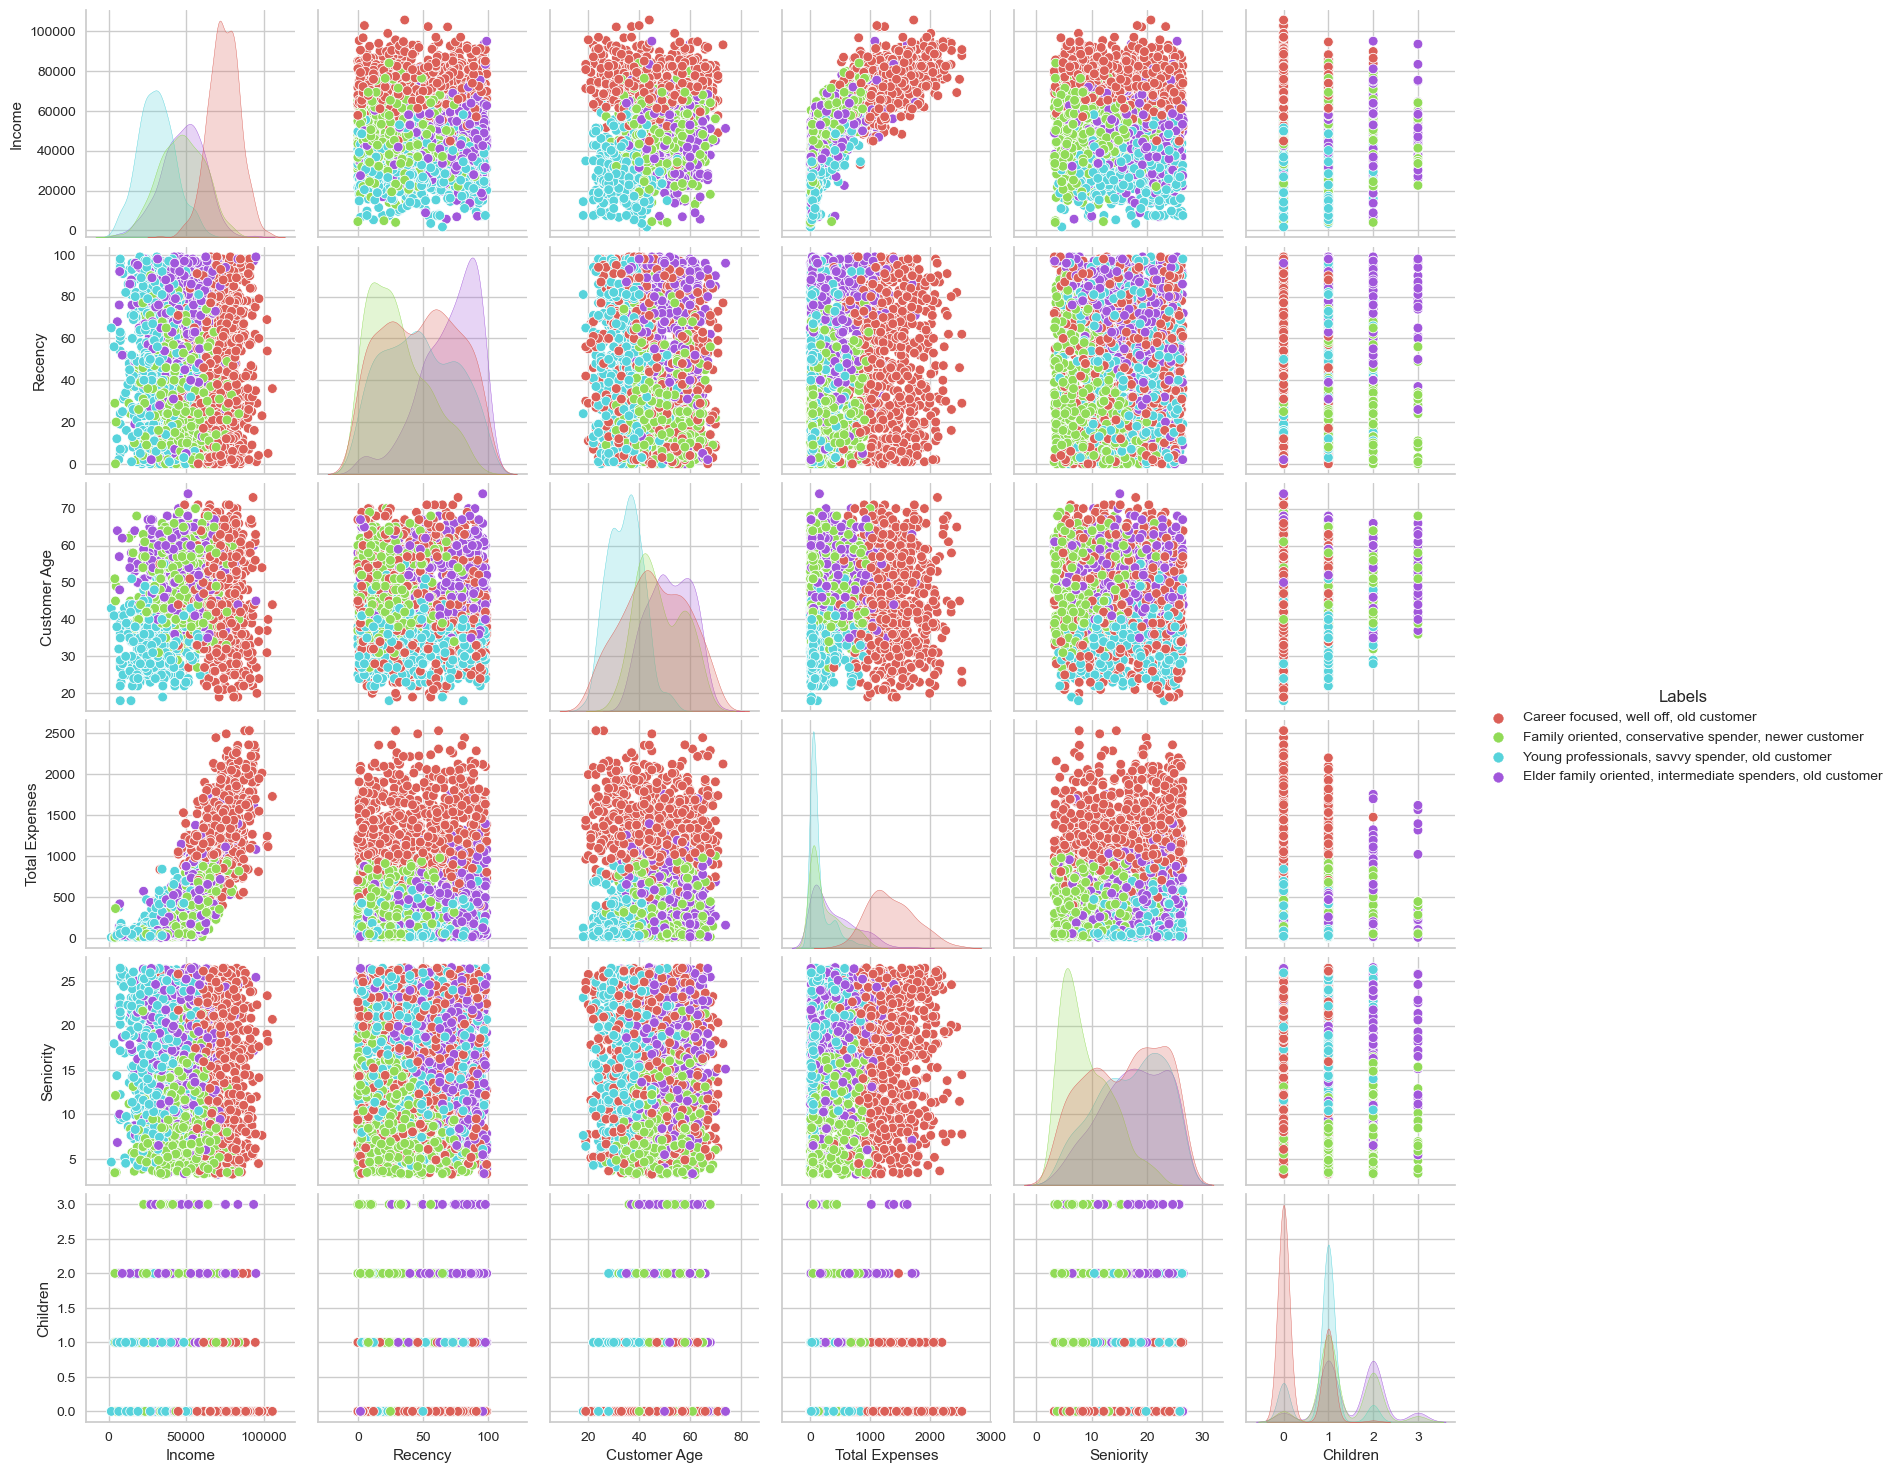

In [34]:
sns.pairplot(segm_pca_kmeans_4_clus, vars=features, hue='Labels', palette=sns.color_palette('hls',4))

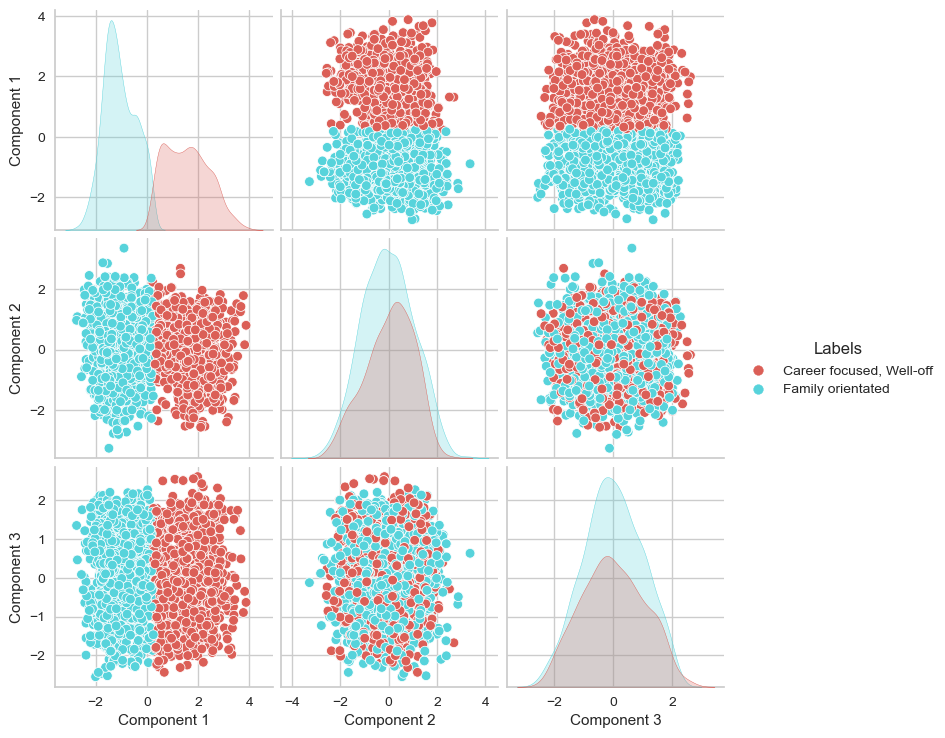

In [37]:
sns.pairplot(segm_pca_kmeans_2_clus, vars=['Component 1', 'Component 2', 'Component 3'], hue='Labels', palette=sns.color_palette('hls',2))

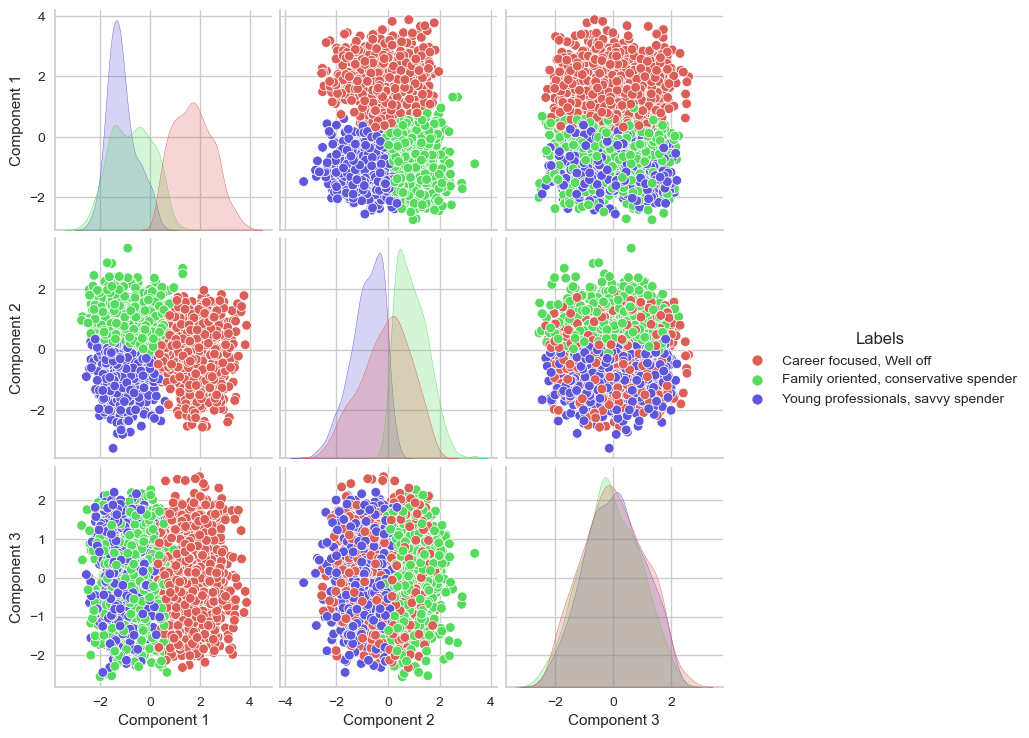

In [36]:
sns.pairplot(segm_pca_kmeans_3_clus, vars=['Component 1', 'Component 2', 'Component 3'], hue='Labels', palette=sns.color_palette('hls',3))

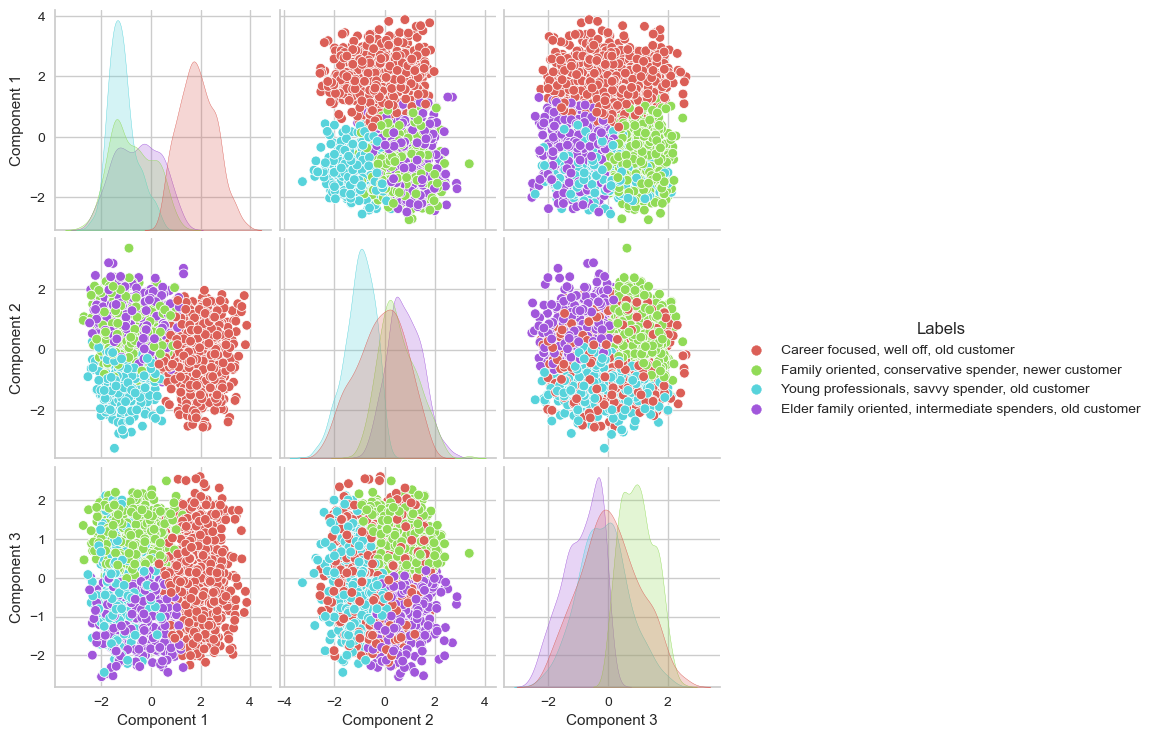

In [35]:
sns.pairplot(segm_pca_kmeans_4_clus, vars=['Component 1', 'Component 2', 'Component 3'], hue='Labels', palette=sns.color_palette('hls',4))

# Conclusion

The use of PCA has improved seperation by allowing us to cluster in the z-space. However as postulated the interpretability is lost somewhat despte the use of correlations.The x-space is better resolved but not sufficiently. The PCA is showing that we can look to exclude recency first and then either seniority or customer age alternativly.